# Castile and Leon: Crops

### Description:
TODO

### Author:
Sergio García Prado ([garciparedes.me](https://garciparedes.me))

In [1]:
rm(list = ls())

In [2]:
library(readr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(RSocrata)
library(ca)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Data Adquisition:

In [3]:
crops.herbaceous <- read.socrata("https://analisis.datosabiertos.jcyl.es/resource/agu2-cspz.csv")

In [4]:
crops.woody <- read.socrata("https://analisis.datosabiertos.jcyl.es/resource/2vwa-si9n.csv")

## Data Exploration:

In [5]:
colnames(crops.herbaceous)

[1] "a_o"                             "codigo_comarca"                 
 [3] "codigo_muncipio"                 "codigo_producto"                
 [5] "codigo_provincia"                "comarca"                        
 [7] "cultivo"                         "grupo_de_cultivo"               
 [9] "municipio"                       "ocupaci_n_primera_regad_o"      
[11] "ocupaci_n_primera_secano"        "ocupaciones_asociadas_regad_o"  
[13] "ocupaciones_asociadas_secano"    "ocupaciones_posteriores_regad_o"
[15] "ocupaciones_posteriores_secano"

#### Remove Unnecesary Columns and Rename Interesting Columns

In [6]:
crops.herbaceous.use <- crops.herbaceous %>%
    select(a_o, codigo_provincia:ocupaci_n_primera_secano) %>%
    rename(year = a_o, 
           code.province = codigo_provincia, 
           region = comarca, 
           crop = cultivo, 
           crop.type = grupo_de_cultivo, 
           town = municipio, 
           area.irrigation = ocupaci_n_primera_regad_o, 
           area.dry = ocupaci_n_primera_secano)

#### View Data Sample

In [7]:
sample_n(crops.herbaceous.use, 10)

,year,code.province,region,crop,crop.type,town,area.irrigation,area.dry
29877,2011,34,CAMPOS,VEZA,LEGUMINOSAS GRANO,VALLE DEL RETORTILLO,6,96
141330,2016,47,SUR,YERO,LEGUMINOSAS GRANO,SIETE IGLESIAS DE TRABANCOS,44,45
56994,2012,42,CAMPO DE GOMARA,GIRASOL,CULTIV. INDUSTRIALES,MATALEBRERAS,NA,13
126134,2015,42,BURGO DE OSMA,ALFALFA,CULTIVOS FORRAJEROS,RECUERDA,NA,3
79991,2013,47,SUR,AVENA,CEREALES GRANO,BOBADILLA DEL CAMPO,2,13
57682,2012,47,CENTRO I,CEBADA,CEREALES GRANO,AMUSQUILLO,85,566
121136,2015,37,ALBA DE TORMES,VEZA PARA FORRAJE,CULTIVOS FORRAJEROS,HORCAJO-MEDIANERO,NA,4
132654,2015,49,CAMPOS-PAN,MAIZ,CEREALES GRANO,TORRES DEL CARRIZAL,35,0
49575,2012,34,EL CERRATO,TRITICALE,CEREALES GRANO,CASTRILLO DE DON JUAN,NA,308
113236,2015,9,ARLANZA,TRIGO,CEREALES GRANO,PINEDA-TRASMONTE,NA,517


In [8]:
summary(crops.herbaceous.use)

      year      code.province      region              crop          
 Min.   :2010   Min.   : 5.00   Length:157965      Length:157965     
 1st Qu.:2011   1st Qu.:24.00   Class :character   Class :character  
 Median :2013   Median :37.00   Mode  :character   Mode  :character  
 Mean   :2013   Mean   :32.26                                        
 3rd Qu.:2015   3rd Qu.:47.00                                        
 Max.   :2016   Max.   :49.00                                        
                                                                     
  crop.type             town           area.irrigation      area.dry      
 Length:157965      Length:157965      Min.   :   0.00   Min.   :    0.0  
 Class :character   Class :character   1st Qu.:   0.00   1st Qu.:    3.0  
 Mode  :character   Mode  :character   Median :   3.00   Median :   18.0  
                                       Mean   :  29.76   Mean   :  119.9  
                                       3rd Qu.:  19.00   3rd Qu.:

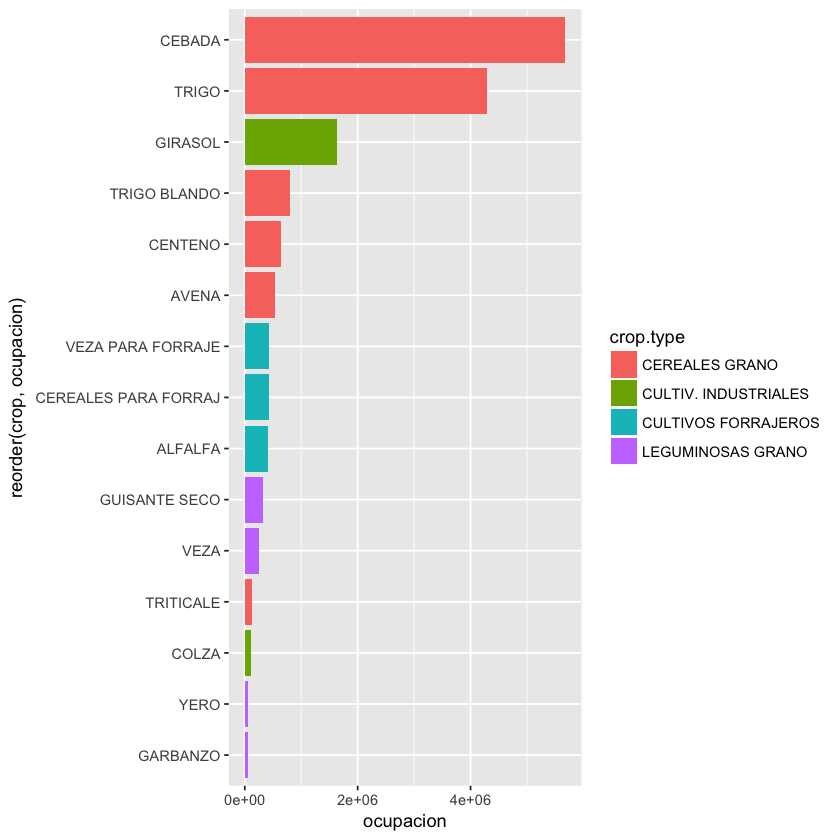

In [63]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.dry) %>%
  filter(area.dry > 0) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.dry, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

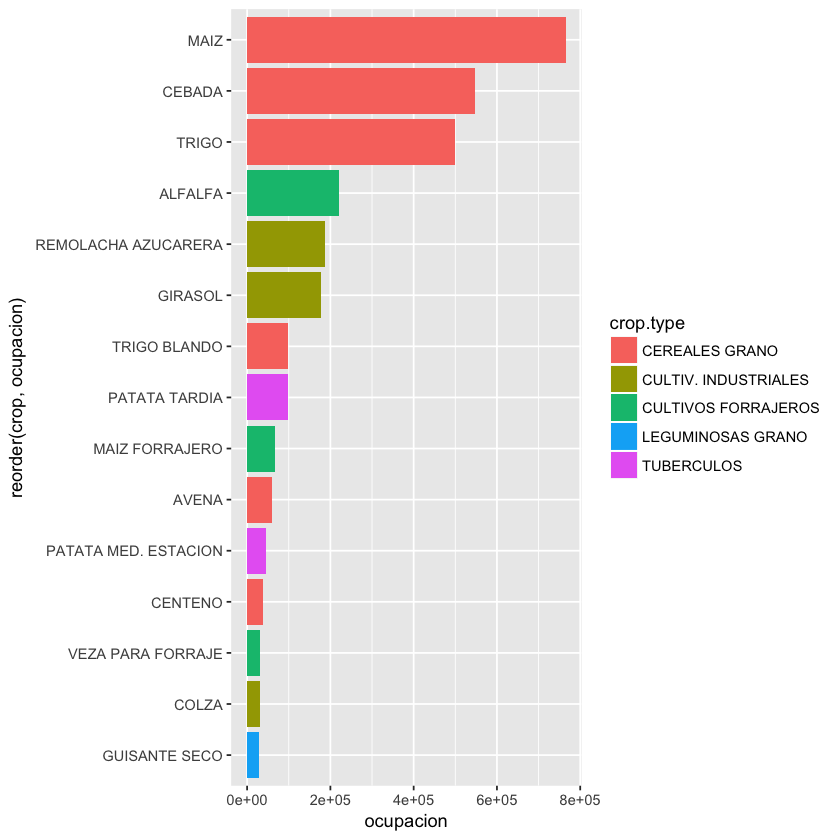

In [66]:
crops.herbaceous.use %>%
  select(crop, crop.type, area.irrigation) %>%
  group_by(crop.type, crop) %>%
  summarise(ocupacion = sum(area.irrigation, na.rm = TRUE)) %>%
  ungroup() %>%
  top_n(15, ocupacion) %>%
  ggplot(aes(x = reorder(crop, ocupacion), y = ocupacion)) + 
    geom_bar(aes(fill = crop.type), stat = "identity") + 
    coord_flip()

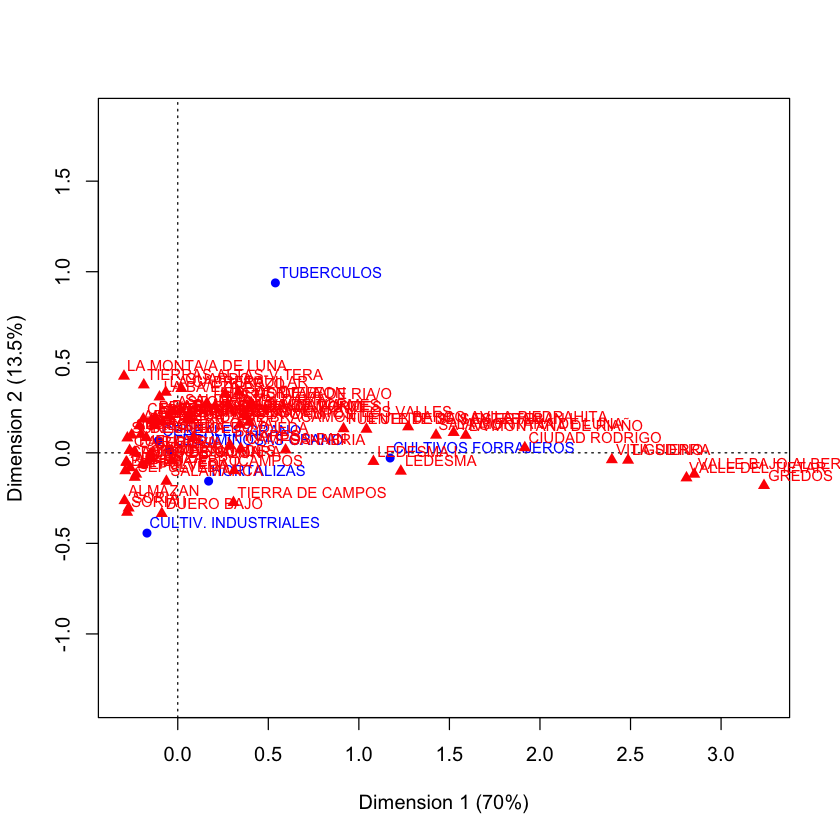

In [11]:
crops.herbaceous.use %>%
    select(crop.type, region, area.dry) %>%
    filter(area.dry > 0) %>%
    xtabs(formula = area.dry ~ .) %>%
    ca() %>% 
    plot()